In [2]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *

In [3]:
data = pd.read_csv('credit_card_default_analysis.csv')

In [4]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
SEX: пол клиента (1 = мужской, 2 = женский )
EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
AGE: возраст в годах
PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
default - индикатор невозврата денежных средств

разделим данные по значению основного критерия: возвратности задолженности

In [5]:
data_def = data.query('default == "1"')
data_con = data.query('default == "0"')

# Задание 1: оценка зависимости возврата задолженности от суммы установленного кредитного лимита

In [6]:
limit_def = data_def.LIMIT_BAL
limit_con = data_con.LIMIT_BAL

Populating the interactive namespace from numpy and matplotlib


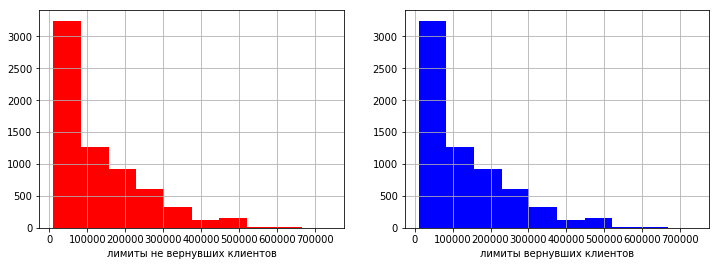

In [7]:
%pylab inline
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(limit_def, color = 'r')
pylab.xlabel('лимиты не вернувших клиентов')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(limit_def, color = 'b')
pylab.xlabel('лимиты вернувших клиентов')

pylab.show()

получившиеся выборки значений лимита для вернувших и не вернувших задолженность являются независимыми, поскольку получены на разных объектах.
из гистограмм видно, что распределения значений кредитных лимитов не являются нормальными, 
для сравнения значения медиан целесообразно использовать критерий Манна-Уитни

рассчитаем 95% доверительные интервалы медианных значений кредитных лимитов

In [8]:
print('95%% confidence interval for the mean: [%f, %f]' % zconfint(limit_def))

95% confidence interval for the mean: [127333.653340, 132885.659499]


In [9]:
print('95%% confidence interval for the mean: [%f, %f]' % zconfint(limit_con))

95% confidence interval for the mean: [176411.914497, 179787.537651]


уже по значениям интервалов видно, что кредитные лимиты у заемщиков, 
погасивших задолженность, выше, чем у тех, кто допустил дефолт
критерий Манна-Уитни должен показать достаточность оснований отклонить нулевую гипотезу о 
равенстве медианных значений

Н0 - средние значения лимитов риска не различаются для заемщиков, вернувших и не вернувших кредиты, p-уровень значимости 0,05

In [10]:
stats.mannwhitneyu(limit_def, limit_con)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

так и есть, р-уровень значимости сильно меньше 0,05, нулевая гипотеза о равенстве медианных значений отвергается

оценим показатель с помощью перестановочного критерия

Н0 - функции распределения обоих выборок совпадают, Н1 - функции распределения одной выборки получается сдвигом распределения другой выборки, p-уровень значимости 0,05

In [11]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [12]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [13]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), list(filter(lambda i: i not in index, range(n)))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

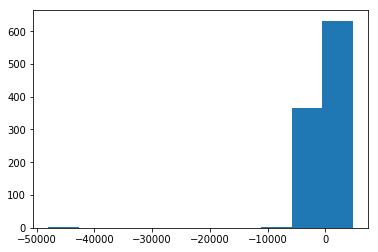

In [14]:
pylab.hist(permutation_zero_dist_ind(limit_def, limit_con, max_combinations = 1000))
pylab.show()

In [15]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [16]:
print("p-value: %f" % permutation_test(limit_def, limit_con, max_permutations = 10000))

p-value: 0.000100


р-уровень значимости меньше 0,05, значит достаточно оснований отклонить нулевую гипотезу об одинаковости распределений выборки, что подтверждает ранее сделанные выводы о наличии значимых различий в суммах лимитов для клиентов, вернувших и не вернувших кредиты

С практической точки зрения я бы сделал вывод о том, что действующая в банке система оценки кредитоспособности заемщиков в некоторой степени работает, поскольку не возвраты кредитов случаются в основном у заемщиков, кому одобрены меньшие суммы. Вероятно, банк в них видел больше рисков.

# Задание 2. Оценка зависимости возвратности задолженности от пола заемщика

In [17]:
sex_def = data_def.SEX
sex_con = data_con.SEX

In [18]:
#поменяем значения признака так, чтобы они были бинарные в формате 0,1. 
sex_d = pd.DataFrame(sex_def)
sex_c = pd.DataFrame(sex_con)
sex_d = sex_d.replace(2, 0)
sex_c = sex_c.replace(2, 0)

Populating the interactive namespace from numpy and matplotlib


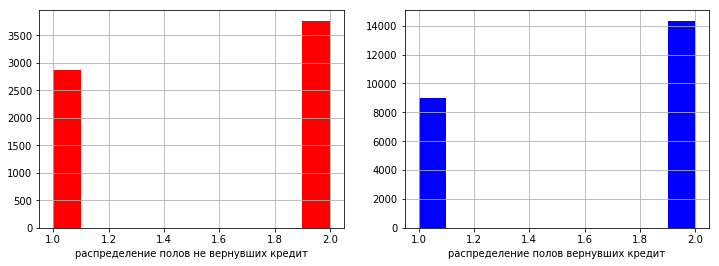

In [19]:
%pylab inline
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(sex_def, color = 'r')
pylab.xlabel('распределение полов не вернувших кредит')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(sex_con, color = 'b')
pylab.xlabel('распределение полов вернувших кредит')

pylab.show()

из гистограмм видно, что в обоих выборках (как вернувших, так и не вернувших кредит), большее число женщин, но в выборке не вернувших кредит разность значимо меньше между количеством мужчин и женщин. 

в данном случае имеем дело с бинарными данными, для которых целесообразно применять критерии разности долей

In [20]:
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [21]:
#оценим доверительные интервалы соотношения мужчин и женщин в выборках для людей, вернувших и не вернувших кредит
conf_interval_sex_d = proportion_confint(sum(sex_d), 
                                            sex_d.shape[0],
                                            method = 'wilson')
conf_interval_sex_c = proportion_confint(sum(sex_c), 
                                            sex_c.shape[0],
                                            method = 'wilson')

In [22]:
print('interval for banner a [%f, %f]' % conf_interval_sex_d)
print('interval for banner b [%f, %f]' % conf_interval_sex_c)

interval for banner a [0.421062, 0.444898]
interval for banner b [0.379627, 0.392110]


видим, что доверительные интервалы не пересекаются, из чего можно сделать вывод о статистически значимой разности в соотношении мужчин и женщин, вернувших и не вернувших кредит.

In [23]:
print(data.SEX.value_counts())

2    18112
1    11888
Name: SEX, dtype: int64


но по первоначальным данным также видно, что в принципе в нашей выборке количество женщин больше, поэтому говорить о какой-либо практической значимости полученных данных сравнения полового состава вернувших и не вернувших кредит сложно

In [24]:
import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [25]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [26]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [27]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [28]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(sex_d, sex_c))

95% confidence interval for a difference between proportions: [0.033635, 0.060548]


In [29]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(sex_d, sex_c)))

p-value: 0.000000


z-критерий разности долей также подтверждает наличие статистически значимых различий в полов составе заемщиков, вернувших и не вернувших кредиты. можно сделать вывод о том, что кредитование мужчин является несколько более рискованным, что целесообразно учитывать при определении кредитоспособности заемщиков, но не означает, что мужчинам вообще нельзя давать кредиты

# Задание 3. Оценка зависимости возвратности кредита от уровня образования заемщика

In [30]:
print(data.EDUCATION.value_counts())

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64


In [31]:
ed = pd.concat([data.EDUCATION.value_counts(), data.EDUCATION.value_counts(normalize = True)], axis = 1)

In [32]:
ed

,EDUCATION,EDUCATION
2,14030,0.467667
1,10585,0.352833
3,4917,0.163900
5,280,0.009333
4,123,0.004100
6,51,0.001700
0,14,0.000467


видим, что в исходных данных доли значений признаков 5,4,6,0 составляют менее 1% от общего объема, в связи с чем, на мой взгляд, целесообразно их вообще не рассматривать, а оставить только признаки 2,1,3 для оценки значимости на возврать долга

In [33]:
ed_def = data_def.EDUCATION
ed_con = data_con.EDUCATION
ed_d = pd.DataFrame(ed_def)
ed_c = pd.DataFrame(ed_con)

In [34]:
ed_d_table = pd.concat([ed_def.value_counts(), ed_def.value_counts(normalize = True)], axis = 1)
ed_d_table

,EDUCATION,EDUCATION
2,3330,0.501808
1,2036,0.306811
3,1237,0.186407
5,18,0.002712
6,8,0.001206
4,7,0.001055


In [35]:
ed_c_table = pd.concat([ed_con.value_counts(), ed_con.value_counts(normalize = True)], axis = 1)
ed_c_table

,EDUCATION,EDUCATION
2,10700,0.457970
1,8549,0.365905
3,3680,0.157507
5,262,0.011214
4,116,0.004965
6,43,0.001840
0,14,0.000599


составим таблицу сопряженности показателей возвратности задолженности в зависимости от уровня обеспеченности

In [36]:
ed_s = pd.concat([ed_def.value_counts(), ed_con.value_counts()], axis = 1, keys = ('def', 'not'))
ed_s

,def,not
0,NaN,14
1,2036.0,8549
2,3330.0,10700
3,1237.0,3680
4,7.0,116
5,18.0,262
6,8.0,43


In [37]:
ed_s.fillna(0, inplace = True)
ed_s

,def,not
0,0.0,14
1,2036.0,8549
2,3330.0,10700
3,1237.0,3680
4,7.0,116
5,18.0,262
6,8.0,43


In [38]:
chi2, p_value, dof, matrix_expected = stats.chi2_contingency(observed = ed_s.values, correction = True)

In [39]:
p_value

1.2332626245415605e-32

In [40]:
m = pd.DataFrame(matrix_expected)
m

,0,1
0,3.0968,10.9032
1,2341.4020,8243.5980
2,3103.4360,10926.5640
3,1087.6404,3829.3596
4,27.2076,95.7924
5,61.9360,218.0640
6,11.2812,39.7188


In [41]:
m.columns = ['def', 'not']
m

,def,not
0,3.0968,10.9032
1,2341.4020,8243.5980
2,3103.4360,10926.5640
3,1087.6404,3829.3596
4,27.2076,95.7924
5,61.9360,218.0640
6,11.2812,39.7188


далее получаем матрицу сопряженности, где в ячейках отражен разность между ожидаемыми и фактическим значениями

In [42]:
s = ed_s - m
s

,def,not
0,-3.0968,3.0968
1,-305.4020,305.4020
2,226.5640,-226.5640
3,149.3596,-149.3596
4,-20.2076,20.2076
5,-43.9360,43.9360
6,-3.2812,3.2812


Populating the interactive namespace from numpy and matplotlib


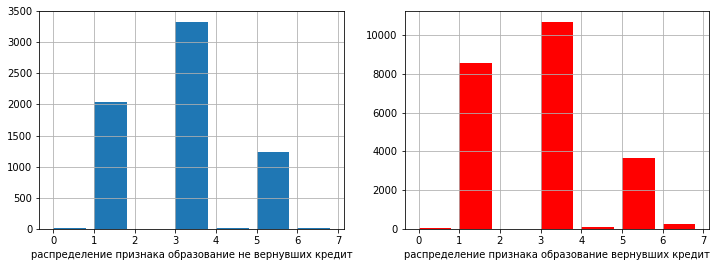

In [43]:
x = [2,1,3,5,4,6,0]

%pylab inline
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
ax = plt.gca()
ax.bar(x, ed_s['def'], align='edge')
pylab.xlabel('распределение признака образование не вернувших кредит')

pylab.subplot(1,2,2)
pylab.grid()
ax = plt.gca()
ax.bar(x, ed_s['not'], align='edge', color = 'r')
pylab.xlabel('распределение признака образование вернувших кредит')

plt.show()

по визуализации данных видно, что распределение объектов в зависимости от признака образование схожи как для выборки по признаку default, так и non default

для применения какого-либо статистического критерия можно привести критерий образования к бинарному виду в формате "выше среднего" и "ниже среднего". оценить влияние критерия образованности на возвратность кредита можно с помощью модели логистической регрессии. 

In [44]:
data_2 = data
data_1 = data['default']
data_2['aboveav'] = data_2['EDUCATION'].apply(lambda x : 1 if x < 2 else 0)
data_2['belowav'] = data_2['EDUCATION'].apply(lambda x : 1 if x > 2 else 0)

In [45]:
data_1 = pd.DataFrame(data_1)
data_1.head()

,default
0,1
1,1
2,0
3,0
4,0


In [47]:
data_a = pd.DataFrame(data_2['aboveav'])
data_b = pd.DataFrame(data_2['belowav'])

In [48]:
data_3 = data_1.assign(aboveav = data_a)

In [49]:
data_3 = data_3.assign(belowav = data_b)

In [50]:
data_3.drop(['default'], axis = 1, inplace = True)
data_3.head()

,aboveav,belowav
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


в итоге получили целевую переменную в виде "дефолт / не дефолт" и признаки образования "выше / ниже среднего". составим для них модель логистической регрессии и посмотрим, в какой степени возвратность кредита определяется уровнем образования

In [51]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2

In [52]:
m1 = smf.Logit(data_1, data_3)
fitted = m1.fit()
print(fitted.summary())

Optimization terminated successfully.
         Current function value: 0.594936
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                30000
Model:                          Logit   Df Residuals:                    29998
Method:                           MLE   Df Model:                            1
Date:                Mon, 14 Oct 2019   Pseudo R-squ.:                 -0.1259
Time:                        21:43:59   Log-Likelihood:                -17848.
converged:                       True   LL-Null:                       -15853.
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
aboveav       -1.4365      0.025    -58.259      0.000      -1.485      -1.388
belowav       -1.1722      0.

получили значение Pseudo R-squ. в размере -0,1259, что говорит о низкой степени влияния переменных образования на результат возврата кредита

для определения зависимости переменных можно также рассчитать коэффициент корреляции Мэтьюса

In [53]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(data_1, data_3.aboveav)

-0.0518326534875196

In [54]:
matthews_corrcoef(data_1, data_3.belowav)

0.017163738914314306

получили очень низкий уровень зависимости переменных. таким образом, критерий образования не оказывает значимого влияния на возвратность кредита

# Задание 4. Оценка влияния семейного положения на возвратность кредита.

In [55]:
mar_def = data_def.MARRIAGE
mar_con = data_con.MARRIAGE

In [56]:
mar_def.head()

0     1
1     2
13    2
16    2
21    1
Name: MARRIAGE, dtype: int64

In [57]:
mar_s = pd.concat([mar_def.value_counts(), mar_con.value_counts()], axis = 1, keys = ('def', 'not'))
mar_s

,def,not
2,3341,12623
1,3206,10453
3,84,239
0,5,49


Populating the interactive namespace from numpy and matplotlib


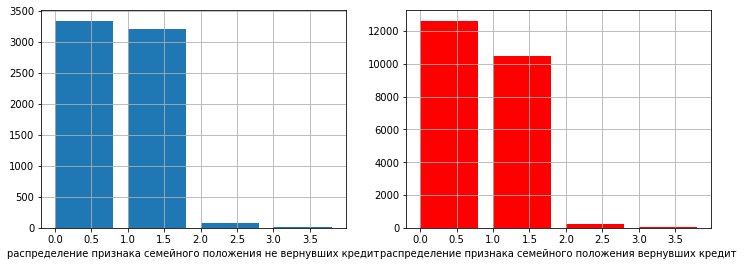

In [58]:
y = [0,1,2,3]

%pylab inline
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
ax = plt.gca()
ax.bar(y, mar_s['def'], align='edge')
pylab.xlabel('распределение признака семейного положения не вернувших кредит')

pylab.subplot(1,2,2)
pylab.grid()
ax = plt.gca()
ax.bar(y, mar_s['not'], align='edge', color = 'r')
pylab.xlabel('распределение признака семейного положения вернувших кредит')

plt.show()

количество объектов с признаками 3 и 0 очень мало, на мой взгляд целесообразно исключить их из выборки и оценивать только влияние признаков 1 и 2.

In [59]:
mar_def = pd.DataFrame(data_def.MARRIAGE)
mar_con = pd.DataFrame(data_con.MARRIAGE)

In [60]:
mar_def = mar_def.query('MARRIAGE != 0')

In [61]:
mar_def = mar_def.query('MARRIAGE != 3')
mar_con = mar_con.query('MARRIAGE != 3')

In [62]:
mar_con = mar_con.query('MARRIAGE != 0')

In [63]:
mar_def = mar_def.replace(2, 0)
mar_con = mar_con.replace(2, 0)

Н0 - критерий семейного положения не влияет на возвратность кредита, p-value 0,05

In [64]:
#оценим доверительные интервалы соотношения женатых и холостых людей в выборках, вернувших и не вернувших кредит
conf_interval_mar_d = proportion_confint(sum(mar_def), 
                                            mar_def.shape[0],
                                            method = 'wilson')
conf_interval_mar_c = proportion_confint(sum(mar_con), 
                                            mar_con.shape[0],
                                            method = 'wilson')

In [65]:
print('interval for median default [%f, %f]' % conf_interval_mar_d)
print('interval for median non default [%f, %f]' % conf_interval_mar_c)

interval for median default [0.477591, 0.501801]
interval for median non default [0.446567, 0.459411]


доверительные интервалы не пересекаются, что может говорить о значимой зависимости возвратности кредита от признака семейного положения

In [66]:
import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

оценим z-критерий для разности долей

In [67]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [68]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [69]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [70]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(mar_def, mar_con))

95% confidence interval for a difference between proportions: [0.023002, 0.050415]


In [71]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(mar_def, mar_con)))

p-value: 0.000000


получили значение р-уровня значимости меньше 0,05, таким образом, существует значимая зависимость возвратности кредита от семейного положения заемщика

# Задание 5. Оценка влияния возраста на возвратность заемщика

In [72]:
age_def = data_def.AGE
age_con = data_con.AGE

Populating the interactive namespace from numpy and matplotlib


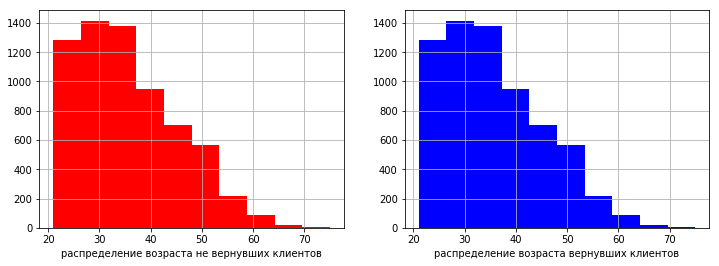

In [73]:
%pylab inline
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(age_def, color = 'r')
pylab.xlabel('распределение возраста не вернувших клиентов')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(age_def, color = 'b')
pylab.xlabel('распределение возраста вернувших клиентов')

pylab.show()

по гистораммам видно, что распределение возраста для вернувших и не вернувших кредит клиентов очень схоже и не является нормальным, для оценки значимости различий целесообразно использовать ранговый критерий Манна_Уитни и перестановочный критерий

In [74]:
print('95%% confidence interval for the mean: [%f, %f]' % zconfint(age_def))

95% confidence interval for the mean: [35.492515, 35.958962]


In [75]:
print('95%% confidence interval for the mean: [%f, %f]' % zconfint(age_con))

95% confidence interval for the mean: [35.300871, 35.533661]


видим, что доверительные интервалы пересекаются и очень близки друг к другу

Н0 - отсутствует значимое различие в возрасте заемщика для вернувших и не вернувших кредит, р-уровень значимости 0,05

In [76]:
stats.mannwhitneyu(age_def, age_con)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

значение р-уровня значимости больше 0,05, что говорит об отсутствии оснований отклонить нулевую теорию об отсутствии значимых различий в возрастах заемщиков, вернувших и не вернувших кредит

оценим также и перестановочный критерий

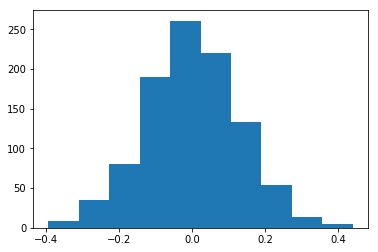

In [77]:
pylab.hist(permutation_zero_dist_ind(age_def, age_con, max_combinations = 1000))
pylab.show()

визуально распределение достаточно похоже на нормальное

In [80]:
print("p-value: %f" % permutation_test(age_def, age_con, max_permutations = 10000))

p-value: 0.014100


видим, что на уровне значимости 0,05 нулевая теория могла бы быть отвергнута, хотя иные критерии показывают отсутствие значимых различий по критерию возраста

как результат в целом можно сделать вывод о том, что отдельные критерии имеют значимую взаимосвязь с  уровнем дефолта заемщиков, отдельные не имеют. но для модели скоринга вероятно важна совокупность взаимодействия различных критериев на целевой показатель